In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt

import tensorflow as tf

import yaml
import time
import glob
# from memory_profiler import profile

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

### download data

In [ ]:
# flist = glob.glob('data/*_batch0.root')
# #flist = glob.glob('/ceph/akhmet/balanced_batches/batch0/*.root')[0:3]

# transformation_dict = yaml.load(open('./transformed_quantities.yml', 'r'), Loader=yaml.FullLoader)

# n_pop_events = 1
# tables = {}

In [ ]:
# f = uproot.open('data/electron_absetabin0_ptbin0_batch0.root')
# t = f['taus']
# # t.show() # print tree content

In [ ]:
# taus = t.arrays(library='ak')
# tau_i = 7 # random tau index for illustrative purposes
# taus

In [ ]:
def get_data(path):
    return uproot.concatenate(f'{path}:taus', library='ak')

In [ ]:
taus = get_data('data/muon_*.root')

In [8]:
tau_i = 7 # random tau index for illustrative purposes
n_taus = len(taus)

In [9]:
ak.num(taus.pfCand_pt), ak.num(taus.ele_pt), ak.num(taus.muon_pt)

(<Array [54, 47, 53, 63, 72, ... 68, 64, 64, 45] type='3075 * int64'>,
 <Array [1, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='3075 * int64'>,
 <Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='3075 * int64'>)

In [10]:
len(taus.fields)

385

### define the grid

In [9]:
grid_types = ['inner', 'outer']
grid_size, grid_left, grid_right = {}, {}, {}

In [10]:
n_cells = {'inner': 11, 'outer': 21}
cell_size = {'inner': 0.02, 'outer': 0.05}

In [11]:
for grid_type in grid_types:
    grid_size[grid_type] = cell_size[grid_type] * n_cells[grid_type]
    grid_left[grid_type], grid_right[grid_type] = - grid_size[grid_type] / 2, grid_size[grid_type] / 2

### derive constituents' features

In [12]:
constituent_types = ['ele', 'muon', 'pfCand']

In [13]:
# count of constituents for each tau
for c_type in constituent_types: 
    taus[f'n_{c_type}'] = ak.num(taus[f'{c_type}_pt'])

In [14]:
taus[tau_i]['n_ele'],  taus[tau_i]['n_muon'], taus[tau_i]['n_pfCand'],

(0, 1, 58)

In [15]:
# more features to be put here

In [16]:
# %%timeit
for c_type in constituent_types: 
    for dim in ['phi', 'eta']:
        taus[f'{c_type}_d{dim}'] = taus[f'{c_type}_{dim}'] - taus[f'tau_{dim}']

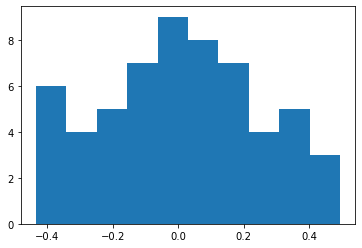

In [17]:
plt.hist(taus[tau_i].pfCand_deta)
plt.show()

### derive inner/outer grid masks

In [18]:
# # %%timeit
# for c_type in constituent_types:
#     for grid_type in grid_types:
#         grid_eta_mask = (taus[f'{c_type}_deta'] > grid_left[grid_type]) & (taus[f'{c_type}_deta'] < grid_right[grid_type])
#         grid_phi_mask = (taus[f'{c_type}_dphi'] > grid_left[grid_type]) & (taus[f'{c_type}_dphi'] < grid_right[grid_type])
#         taus[f'{grid_type}_grid_{c_type}_mask'] = grid_eta_mask * grid_phi_mask

In [19]:
grid_mask_dict = {'inner': {}, 'outer': {}}

In [20]:
# %%timeit
for c_type in constituent_types:
    for grid_type in grid_types:
        grid_eta_mask = (taus[f'{c_type}_deta'] > grid_left[grid_type]) & (taus[f'{c_type}_deta'] < grid_right[grid_type])
        grid_phi_mask = (taus[f'{c_type}_dphi'] > grid_left[grid_type]) & (taus[f'{c_type}_dphi'] < grid_right[grid_type])
        grid_mask_dict[grid_type][c_type] = grid_eta_mask * grid_phi_mask
    taus[f'inner_grid_{c_type}_mask'] = grid_mask_dict['inner'][c_type]
    taus[f'outer_grid_{c_type}_mask'] = grid_mask_dict['outer'][c_type] * (~grid_mask_dict['inner'][c_type])

In [21]:
for c_type in constituent_types:  
    for grid_type in grid_types:
        print(f'{c_type}: total {sum(taus[f"{grid_type}_grid_{c_type}_mask"][tau_i])} constituents in the {grid_type} cone for tau with i={tau_i}')
    print()

ele: total 0 constituents in the inner cone for tau with i=7
ele: total 0 constituents in the outer cone for tau with i=7

muon: total 1 constituents in the inner cone for tau with i=7
muon: total 0 constituents in the outer cone for tau with i=7

pfCand: total 3 constituents in the inner cone for tau with i=7
pfCand: total 55 constituents in the outer cone for tau with i=7



In [22]:
print(15*'*')
for c_type in constituent_types: 
    print()
    for grid_type in grid_types:  
        grid_mask = taus[f"{grid_type}_grid_{c_type}_mask"]
        print(f'{c_type}: total count of constituents per tau in the {grid_type} cone\n{ak.sum(grid_mask, axis=1)}')
        print()
    print(15*'*')

***************

ele: total count of constituents per tau in the inner cone
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

ele: total count of constituents per tau in the outer cone
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

***************

muon: total count of constituents per tau in the inner cone
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

muon: total count of constituents per tau in the outer cone
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

***************

pfCand: total count of constituents per tau in the inner cone
[3, 3, 4, 4, 8, 2, 5, 3, 9, 4, 4, 6, 4, 4, ... 6, 6, 6, 3, 6, 8, 4, 6, 5, 6, 4, 7, 5]

pfCand: total count of constituents per tau in the outer cone
[51, 44, 49, 59, 64, 46, 55, 55, 53, 35, ... 64, 66, 59, 61, 51, 57, 62, 56, 52, 40]

***************


### derive cell indices 

In [23]:
# %%timeit
for c_type in constituent_types: 
    for grid_type in grid_types:
        # get grid indices by affine transforming the grid to an array of grid indices np.arange(n_inner_cells) and then flooring to the nearest integer   
        grid_eta_ids = np.floor((taus[f'{c_type}_deta'] - grid_left[grid_type]) / grid_size[grid_type] * n_cells[grid_type]) 
        grid_phi_ids = np.floor((taus[f'{c_type}_dphi'] - grid_left[grid_type]) / grid_size[grid_type] * n_cells[grid_type])

#         # add for each tau two branches (one for inner and one for outer grid) which store for each constituent a tuple: 
#         # tuple: (index in constituent list, eta index on grid, phi index on grid)
#         grid_ids = ak.zip([grid_eta_ids, grid_phi_ids])
#         grid_ids = ak.zip([ak.local_index(grid_eta_ids, axis=1), grid_eta_ids, grid_phi_ids])

#         # mask with None those consituents which don't belong to the corresponding grid
#         grid_ids = ak.mask(grid_ids, taus[f'{grid_type}_grid_{c_type}_mask']) 

#         # additionally, can fill Nones with some values
#         grid_ids = ak.fill_none(grid_ids, -1) 

        taus[f'{grid_type}_grid_{c_type}_indices_eta'] = grid_eta_ids
        taus[f'{grid_type}_grid_{c_type}_indices_phi'] = grid_phi_ids
#         taus[f'{grid_type}_grid_{c_type}_indices'] = grid_ids

In [24]:
print(15*'*')
for c_type in constituent_types: 
    for grid_type in grid_types:      
        grid_mask = taus[f"{grid_type}_grid_{c_type}_mask"]
        print()
        print(f'{c_type}: eta indices of constituents for tau with i={tau_i} in the {grid_type} cone\n{taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i]}')
    print(15*'*')

***************

ele: eta indices of constituents for tau with i=7 in the inner cone
[]

ele: eta indices of constituents for tau with i=7 in the outer cone
[]
***************

muon: eta indices of constituents for tau with i=7 in the inner cone
[5]

muon: eta indices of constituents for tau with i=7 in the outer cone
[]
***************

pfCand: eta indices of constituents for tau with i=7 in the inner cone
[0, 5, 8]

pfCand: eta indices of constituents for tau with i=7 in the outer cone
[6, 12, 17, 16, 5, 4, 3, 12, 15, 9, 8, 1, ... 9, 17, 14, 20, 12, 10, 10, 10, 9, 8, 6]
***************


### validating indices

In [25]:
grid_type = 'outer'
c_type = 'pfCand'
tau_i = 100

In [41]:
grid_mask = taus[f'{grid_type}_grid_{c_type}_mask']
grid_coord = ak.to_pandas(taus[[f'{c_type}_deta', f'{c_type}_dphi', ]][grid_mask][tau_i])
grid_coord

,pfCand_deta,pfCand_dphi
entry,,
0,-0.101767,-0.187030
1,0.171069,-0.400903
2,0.426692,0.027528
3,-0.039692,0.359960
4,0.023115,-0.220917
...,...,...
67,-0.048848,-0.163678
68,-0.057637,0.159658
69,-0.092428,0.310460


In [42]:
eta_indices = taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i].tolist()
phi_indices = taus[f"{grid_type}_grid_{c_type}_indices_phi"][grid_mask][tau_i].tolist()
for i,j in zip(eta_indices, phi_indices):
    print(i,j)

8.0 6.0
13.0 2.0
19.0 11.0
9.0 17.0
10.0 6.0
15.0 18.0
1.0 8.0
2.0 5.0
4.0 17.0
4.0 15.0
9.0 2.0
16.0 6.0
16.0 15.0
9.0 15.0
12.0 15.0
13.0 7.0
7.0 19.0
13.0 15.0
2.0 5.0
7.0 6.0
11.0 7.0
9.0 5.0
7.0 19.0
17.0 7.0
15.0 4.0
14.0 12.0
13.0 5.0
9.0 20.0
10.0 17.0
5.0 3.0
6.0 2.0
10.0 6.0
8.0 19.0
17.0 14.0
8.0 4.0
15.0 12.0
15.0 3.0
18.0 9.0
15.0 5.0
16.0 8.0
6.0 3.0
9.0 13.0
15.0 13.0
15.0 17.0
11.0 18.0
10.0 17.0
8.0 5.0
19.0 10.0
12.0 13.0
16.0 12.0
11.0 13.0
7.0 16.0
12.0 1.0
10.0 6.0
3.0 6.0
12.0 19.0
20.0 11.0
20.0 10.0
18.0 7.0
14.0 12.0
13.0 5.0
13.0 15.0
12.0 6.0
12.0 13.0
11.0 1.0
10.0 14.0
10.0 19.0
9.0 7.0
9.0 13.0
8.0 16.0
6.0 16.0
5.0 6.0


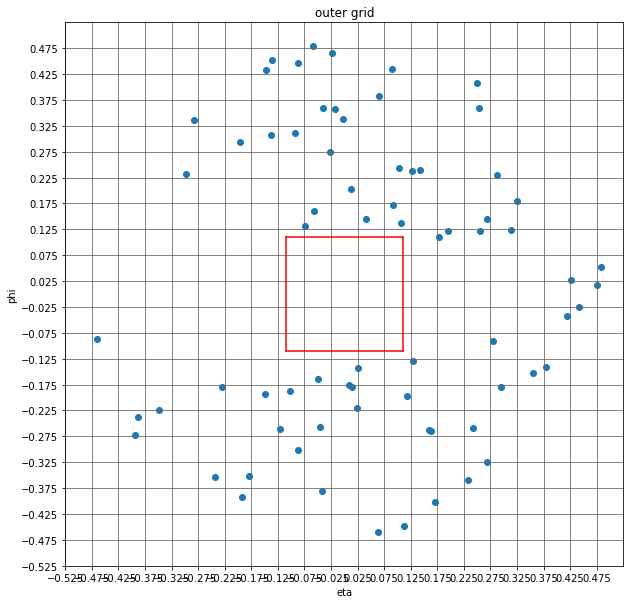

In [43]:
fig, ax = plt.subplots(1, figsize=(10, 10))

if grid_type != 'inner':
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_right['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_left['inner']], [grid_left['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_left['inner'], grid_left['inner']], 'r')
    ax.plot([grid_right['inner'], grid_right['inner']], [grid_left['inner'], grid_right['inner']], 'r')

ax.scatter(x=grid_coord[f'{c_type}_deta'], y=grid_coord[f'{c_type}_dphi'])

ax.set_xlim(grid_left[grid_type], grid_right[grid_type])
ax.set_ylim(grid_left[grid_type], grid_right[grid_type])
ax.set_xticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))
ax.set_yticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))

ax.set_xlabel('eta')
ax.set_ylabel('phi')
ax.set_title(f'{grid_type} grid')

plt.grid(b=True, which='major', color='#666666', linestyle='-') 

plt.show()

### fill final tensor

In [29]:
# @nb.jit()
def get_grid_mask(i_tau, c_type, grid_type):
    grid_mask = taus[i_tau][f'{grid_type}_grid_{c_type}_mask']
    return grid_mask

In [44]:
# @nb.jit()
def get_fill_indices(i_tau, c_type, grid_type, grid_mask):
    indices_eta = taus[i_tau][f'{grid_type}_grid_{c_type}_indices_eta'][grid_mask]
    indices_phi = taus[i_tau][f'{grid_type}_grid_{c_type}_indices_phi'][grid_mask]
    return indices_eta, indices_phi

In [45]:
# @nb.jit()
def get_fill_values(i_tau, c_type, grid_mask):
    fill_values = taus[i_tau][fill_branches[c_type]][grid_mask]
    return fill_values

In [46]:
# branches which will be stored 
fill_branches = {'pfCand': ['pfCand_pt', 'pfCand_deta', 'pfCand_dphi', 'pfCand_mass',]}
c_type = 'pfCand'

In [47]:
# initialize tensors to be filled 
grid_tensors = {}
for grid_type in grid_types:
    grid_tensors[grid_type] = np.zeros((n_taus, n_cells[grid_type], n_cells[grid_type], len(fill_branches[c_type])))

In [48]:
# dictionaries to store timing
get_mask_times = {'inner': [], 'outer': []}
get_fill_indices_times = {'inner': [], 'outer': []}
get_fill_values_times = {'inner': [], 'outer': []}
put_times = {'inner': [], 'outer': []}

program_starts = time.time()
for i_tau, tau in enumerate(taus):
    for grid_type in grid_types:        
        begin_iter = time.time()
        # get mask
#         grid_mask = taus[i_tau][f'{grid_type}_grid_{c_type}_mask']
        grid_mask = get_grid_mask(i_tau, c_type, grid_type)
        after_get_mask = time.time()
        get_mask_times[grid_type].append(after_get_mask - begin_iter)
   
        # get indices
#         indices_eta = taus[i_tau][f'{grid_type}_grid_{c_type}_indices_eta'][grid_mask]
#         indices_phi = taus[i_tau][f'{grid_type}_grid_{c_type}_indices_phi'][grid_mask]
        indices_eta, indices_phi = get_fill_indices(i_tau, c_type, grid_type, grid_mask)
        indices_eta, indices_phi = ak.values_astype(indices_eta, 'int32'), ak.values_astype(indices_phi, 'int32')
        after_get_fill_indices = time.time()
        get_fill_indices_times[grid_type].append(after_get_fill_indices - after_get_mask)
        
        # get values
        values_to_fill = get_fill_values(i_tau, c_type, grid_mask)
#         values_to_fill = taus[i_tau][fill_branches[c_type]][grid_mask]
        values_to_fill = ak.to_pandas(values_to_fill).values
        after_get_fill_values = time.time()
        get_fill_values_times[grid_type].append(after_get_fill_values - after_get_fill_indices)
        
        # put them in the tensor
        grid_tensors[grid_type][i_tau, indices_eta, indices_phi, :] = values_to_fill
        after_put = time.time()
        put_times[grid_type].append(after_put - after_get_fill_values)       
program_ends = time.time()

In [49]:
print(f'Processed {n_taus} taus in {program_ends - program_starts} seconds\n')
for grid_type in grid_types:
    print(f'--- {grid_type} cell')
    print(f'median get_grid_mask() time: {np.median(get_mask_times[grid_type])}')
    print(f'median get_fill_indices() time: {np.median(get_fill_indices_times[grid_type])}')
    print(f'median get_fill_values() time: {np.median(get_fill_values_times[grid_type])}')
    print(f'median np.put() time: {np.median(put_times[grid_type])}')
    print()

Processed 3075 taus in 33.11022615432739 seconds

--- inner cell
median get_grid_mask() time: 0.00011777877807617188
median get_fill_indices() time: 0.0006060600280761719
median get_fill_values() time: 0.004312992095947266
median np.put() time: 0.00018906593322753906

--- outer cell
median get_grid_mask() time: 0.0001361370086669922
median get_fill_indices() time: 0.0006084442138671875
median get_fill_values() time: 0.004324674606323242
median np.put() time: 0.00019598007202148438



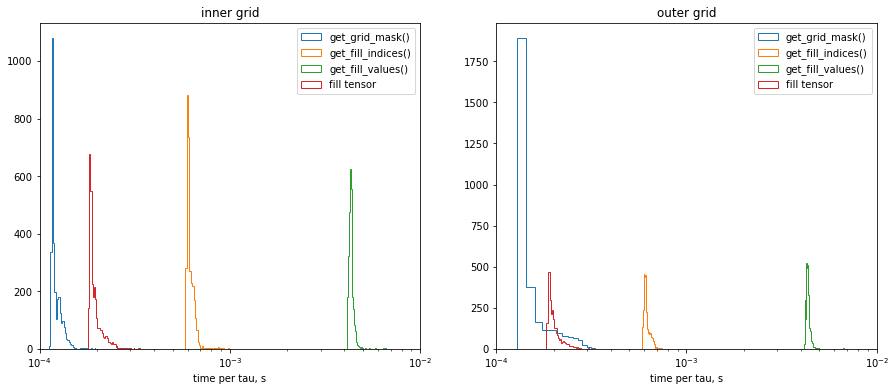

In [50]:
f, ax = plt.subplots(1, 2, figsize=(15,6))
for i, grid_type in enumerate(grid_types):
    ax[i].hist(get_mask_times[grid_type], histtype='step', bins=100, label='get_grid_mask()')
    ax[i].hist(get_fill_indices_times[grid_type], histtype='step', bins=100, label='get_fill_indices()')
    ax[i].hist(get_fill_values_times[grid_type], histtype='step', bins=100, label='get_fill_values()')
    ax[i].hist(put_times[grid_type], histtype='step', bins=100, label='fill tensor')
    ax[i].set_xlabel('time per tau, s')
    ax[i].set_xscale('log')
    ax[i].set_xlim((1e-4, 1e-2))
    ax[i].set_title(f'{grid_type} grid')
    ax[i].legend()

### validating final tensor

In [51]:
grid_type = 'outer'
c_type = 'pfCand'
tau_i = 100

In [52]:
grid_mask = taus[f'{grid_type}_grid_{c_type}_mask']
grid_coord = ak.to_pandas(taus[[f'{c_type}_deta', f'{c_type}_dphi', ]][grid_mask][tau_i])
grid_coord

,pfCand_deta,pfCand_dphi
entry,,
0,-0.101767,-0.187030
1,0.171069,-0.400903
2,0.426692,0.027528
3,-0.039692,0.359960
4,0.023115,-0.220917
...,...,...
67,-0.048848,-0.163678
68,-0.057637,0.159658
69,-0.092428,0.310460


In [42]:
eta_indices = taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i].tolist()
phi_indices = taus[f"{grid_type}_grid_{c_type}_indices_phi"][grid_mask][tau_i].tolist()
for i,j in zip(eta_indices, phi_indices):
    print(i,j)

8.0 6.0
13.0 2.0
19.0 11.0
9.0 17.0
10.0 6.0
15.0 18.0
1.0 8.0
2.0 5.0
4.0 17.0
4.0 15.0
9.0 2.0
16.0 6.0
16.0 15.0
9.0 15.0
12.0 15.0
13.0 7.0
7.0 19.0
13.0 15.0
2.0 5.0
7.0 6.0
11.0 7.0
9.0 5.0
7.0 19.0
17.0 7.0
15.0 4.0
14.0 12.0
13.0 5.0
9.0 20.0
10.0 17.0
5.0 3.0
6.0 2.0
10.0 6.0
8.0 19.0
17.0 14.0
8.0 4.0
15.0 12.0
15.0 3.0
18.0 9.0
15.0 5.0
16.0 8.0
6.0 3.0
9.0 13.0
15.0 13.0
15.0 17.0
11.0 18.0
10.0 17.0
8.0 5.0
19.0 10.0
12.0 13.0
16.0 12.0
11.0 13.0
7.0 16.0
12.0 1.0
10.0 6.0
3.0 6.0
12.0 19.0
20.0 11.0
20.0 10.0
18.0 7.0
14.0 12.0
13.0 5.0
13.0 15.0
12.0 6.0
12.0 13.0
11.0 1.0
10.0 14.0
10.0 19.0
9.0 7.0
9.0 13.0
8.0 16.0
6.0 16.0
5.0 6.0


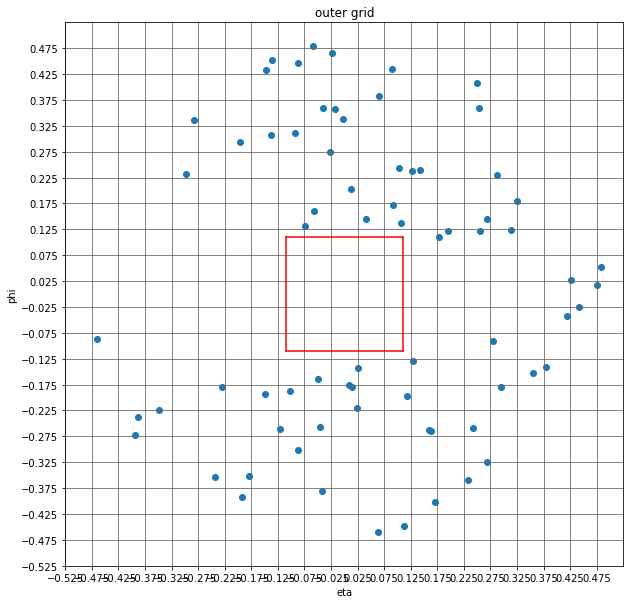

In [43]:
fig, ax = plt.subplots(1, figsize=(10, 10))

if grid_type != 'inner':
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_right['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_left['inner']], [grid_left['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_left['inner'], grid_left['inner']], 'r')
    ax.plot([grid_right['inner'], grid_right['inner']], [grid_left['inner'], grid_right['inner']], 'r')

ax.scatter(x=grid_coord[f'{c_type}_deta'], y=grid_coord[f'{c_type}_dphi'])

ax.set_xlim(grid_left[grid_type], grid_right[grid_type])
ax.set_ylim(grid_left[grid_type], grid_right[grid_type])
ax.set_xticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))
ax.set_yticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))

ax.set_xlabel('eta')
ax.set_ylabel('phi')
ax.set_title(f'{grid_type} grid')

plt.grid(b=True, which='major', color='#666666', linestyle='-') 

plt.show()

### previous version

**Note:** currently, filling with indices works incorrectly. Input to np.put() should be different.

* Ways out: try simple indexing for filling -> make 3 arrays [eta_idx], [phi_idx], [f_idx] and then  
tensor[tau_idx, eta_idx, phi_idx, f_idx] = values  
more in advanced indexing: https://numpy.org/doc/stable/reference/arrays.indexing.html

* or make SparseTensor() and then convert it into dense one


In [25]:
fill_branches = {'pfCand': ['pfCand_pt', 'pfCand_deta', 'pfCand_dphi', 'pfCand_mass',]}
c_type = 'pfCand'

In [26]:
grid_tensors = {}
for grid_type in grid_types:
    grid_tensors[grid_type] = np.zeros((n_taus, n_cells[grid_type], n_cells[grid_type], len(fill_branches[c_type])))

In [116]:
# @nb.jit()
def get_fill_indices(grid_type, i_tau, c_type): 
    grid_mask = taus[i_tau][f'{grid_type}_grid_{c_type}_mask']
    i_eta, i_phi, i_feature = ak.broadcast_arrays(taus[i_tau][f'{grid_type}_grid_{c_type}_indices_eta'][grid_mask],
                                                      taus[i_tau][f'{grid_type}_grid_{c_type}_indices_phi'][grid_mask],
                                                      np.arange(len(fill_branches[c_type]), dtype=np.float32)[:, np.newaxis])
    i_eta_phi_feature = ak.zip([i_eta, i_phi, i_feature])
    indices_to_fill = ak.flatten(i_eta_phi_feature, axis=1)
    indices_to_fill = ak.values_astype(indices_to_fill, 'int32')
    return ak.to_list(indices_to_fill)

In [88]:
# @nb.jit()
def get_fill_values(grid_type, i_tau, c_type): 
    grid_mask = taus[i_tau][f'{grid_type}_grid_{c_type}_mask']
    values_to_fill = ak.to_pandas(taus[i_tau][fill_branches[c_type]][grid_mask]).values
    values_to_fill = values_to_fill.transpose().flatten()
    return values_to_fill

In [90]:
get_fill_indices_times = {'inner': [], 'outer': []}
get_fill_values_times = {'inner': [], 'outer': []}
put_times = {'inner': [], 'outer': []}

program_starts = time.time()
for i_tau, tau in enumerate(taus):
    for grid_type in grid_types:        
        begin_iter = time.time()
        # get indices
        indices_to_fill = get_fill_indices(grid_type, i_tau, c_type)
        after_get_fill_indices = time.time()
        get_fill_indices_times[grid_type].append(after_get_fill_indices - begin_iter)
        
        # get values
        values_to_fill = get_fill_values(grid_type, i_tau, c_type)
        after_get_fill_values = time.time()
        get_fill_values_times[grid_type].append(after_get_fill_values - after_get_fill_indices)
        
        # put them in the tensor
        np.put(grid_tensors[grid_type][i_tau], indices_to_fill, values_to_fill)
        after_put = time.time()
        put_times[grid_type].append(after_put - after_get_fill_values)       
program_ends = time.time()

In [91]:
print(f'Processed {n_taus} taus in {program_ends - program_starts} seconds\n')
for grid_type in grid_types:
    print(f'--- {grid_type} cell')
    print(f'median get_fill_indices() time: {np.median(get_fill_indices_times[grid_type])}')
    print(f'median get_fill_values() time: {np.median(get_fill_values_times[grid_type])}')
    print(f'median np.put() time: {np.median(put_times[grid_type])}')
    print()

Processed 3075 taus in 72.73913288116455 seconds

--- inner cell
median get_fill_indices() time: 0.0031423568725585938
median get_fill_values() time: 0.004656553268432617
median np.put() time: 3.4809112548828125e-05

--- outer cell
median get_fill_indices() time: 0.0102081298828125
median get_fill_values() time: 0.005046844482421875
median np.put() time: 0.0002808570861816406



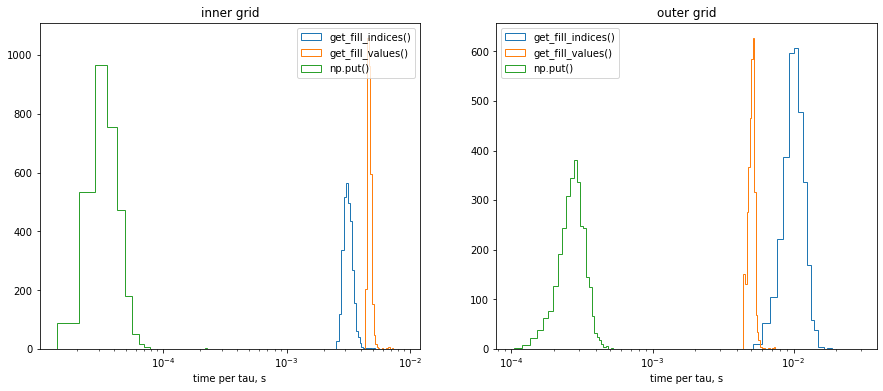

In [152]:
f, ax = plt.subplots(1, 2, figsize=(15,6))
for i, grid_type in enumerate(grid_types):
    ax[i].hist(get_fill_indices_times[grid_type], histtype='step', bins=30, label='get_fill_indices()')
    ax[i].hist(get_fill_values_times[grid_type], histtype='step', bins=30, label='get_fill_values()')
    ax[i].hist(put_times[grid_type], histtype='step', bins=30, label='np.put()')
    ax[i].set_xlabel('time per tau, s')
    ax[i].set_xscale('log')
    ax[i].set_title(f'{grid_type} grid')
    ax[i].legend()
#     ax[i].show()

### misc.

In [117]:
get_fill_indices('inner', 7, 'pfCand')

[(0, 7, 0),
 (5, 5, 0),
 (8, 1, 0),
 (0, 7, 1),
 (5, 5, 1),
 (8, 1, 1),
 (0, 7, 2),
 (5, 5, 2),
 (8, 1, 2),
 (0, 7, 3),
 (5, 5, 3),
 (8, 1, 3)]

In [118]:
get_fill_values('inner', 7, 'pfCand')

array([ 9.06738281e-01,  3.15781250e+01,  3.33593750e+00, -1.07780635e-01,
        7.17937946e-05,  5.26246578e-02,  3.37264538e-02,  4.25577164e-05,
       -7.33020902e-02,  1.39526367e-01,  1.05712891e-01, -0.00000000e+00],
      dtype=float32)

In [119]:
grid_mask = taus[7][f'inner_grid_pfCand_mask']
ak.to_pandas(taus[7][fill_branches['pfCand']][grid_mask])

,pfCand_pt,pfCand_deta,pfCand_dphi,pfCand_mass
entry,,,,
0,0.906738,-0.107781,0.033726,0.139526
1,31.578125,0.000072,0.000043,0.105713
2,3.335938,0.052625,-0.073302,-0.000000


In [121]:
np.put(grid_tensors['inner'][7], get_fill_indices('inner', 7, 'pfCand'), get_fill_values('inner', 7, 'pfCand'))

In [122]:
grid_tensors['inner'][7, 0, 0, 0], grid_tensors['inner'][7, 0, 0, 1], grid_tensors['inner'][7, 0, 0, 2]

(-0.10778063535690308, 0.105712890625, 3.3359375)

In [127]:
a = np.zeros((12, 12, 1))

In [135]:
ind = [[0, 7, 0],
 [5, 5, 0],
 [8, 1, 0],
]

In [136]:
np.put(a, ind, [1,2,3])

In [137]:
a[:, :, 0]

array([[3., 2., 0., 0., 0., 2., 0., 2., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [138]:
np.sum(a != 0)

5

In [142]:
tf.sparse.to_dense(tf.SparseTensor(get_fill_indices('inner', 7, 'pfCand'), get_fill_values('inner', 7, 'pfCand'), (12, 12, 4)))

InvalidArgumentError: indices[3] = [0,7,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]

## [misc]

### single fill

In [32]:
eta_i, phi_i, feature_i = ak.broadcast_arrays(taus[tau_i]['inner_grid_pfCand_indices_eta'][inner_grid_mask[tau_i]],
                            taus[tau_i]['inner_grid_pfCand_indices_phi'][inner_grid_mask[tau_i]],
                            np.arange(len(pf_branches), dtype=np.float32)[:, np.newaxis])
eta_i

<Array [[0, 5, 8], [0, 5, ... 5, 8], [0, 5, 8]] type='4 * 3 * float32'>

In [35]:
eta_phi_feature_i = ak.zip([eta_i, phi_i, feature_i])

<Array [[(0, 7, 0), (5, 5, ... ), (8, 1, 3)]] type='4 * 3 * (float32, float32, f...'>

In [36]:
eta_phi_feature_i[0], eta_phi_feature_i[1], eta_phi_feature_i[2],

(<Array [(0, 7, 0), (5, 5, 0), (8, 1, 0)] type='3 * (float32, float32, float32)'>,
 <Array [(0, 7, 1), (5, 5, 1), (8, 1, 1)] type='3 * (float32, float32, float32)'>,
 <Array [(0, 7, 2), (5, 5, 2), (8, 1, 2)] type='3 * (float32, float32, float32)'>)

In [38]:
indices_to_fill = ak.flatten(eta_phi_feature_i, axis=1)
indices_to_fill = ak.values_astype(indices_to_fill, 'int32')
indices_to_fill = ak.to_list(indices_to_fill)
# indices_to_fill = ak.to_numpy(indices_to_fill)

In [117]:
values_to_fill = ak.to_pandas(taus[tau_i][pf_branches]).values
values_to_fill = values_to_fill.transpose().flatten()
values_to_fill.shape

(232,)

In [26]:
pf_branches = ['pfCand_pt', 'pfCand_deta', 'pfCand_dphi', ]

In [28]:
tau_df = ak.to_pandas(taus[pf_branches + ['inner_grid_pfCand_indices', 'inner_grid_pfCand_mask']])
n_taus = len(tau_df.index.levels[0])
n_taus

3075

In [29]:
tau_df

pfCand_pt pfCand_deta pfCand_dphi inner_grid_pfCand_indices  \
                                                                         0   
entry subentry                                                               
0     0         0.645508   -0.083589    0.347632                       1.0   
      1         0.815918   -0.220189   -0.278948                      -6.0   
      2         0.566406   -0.029388   -0.143703                       4.0   
      3         0.729004   -0.256812   -0.088234                      -8.0   
      4         0.873047    0.156836    0.265015                      13.0   
...                  ...         ...         ...                       ...   
3074  40        4.882812   -0.120702    0.079892                      -1.0   
      41        0.625488   -0.201454    0.234198                      -5.0   
      42        0.691406   -0.288065   -0.149407                      -9.0   
      43        0.451904   -0.322857    0.234294                     -11.0   
      44        0.569824   -0.357465    0.337900                     -13.0   

                     inner_grid_pfCand_mask  
                   1                         
entry subentry                               
0     0         22.0                  False  
      1         -9.0                  False  
      2         -2.0                  False  
      3          1.0                  False  
      4         18.0                  False  
...              ...                    ...  
3074  40         9.0                  False  
      41        17.0                  False  
      42        -2.0                  False  
      43        17.0                  False  
      44        22.0                  False  

[212954 rows x 6 columns]

In [31]:
inner_cand_ids = tau_df.index[tau_df['inner_grid_pfCand_mask']]
inner_grid_ids = tau_df.loc[inner_cand_ids]['inner_grid_pfCand_indices']
inner_grid_ids

0    1
entry subentry          
0     23        5.0  5.0
      43        9.0  4.0
      45        4.0  2.0
1     2         3.0  0.0
      20        5.0  5.0
...             ...  ...
3074  0         3.0  0.0
      11        5.0  5.0
      13        8.0  0.0
      14        0.0  9.0
      31        9.0  2.0

[15853 rows x 2 columns]

In [32]:
inner_grid_fill = tau_df.loc[inner_cand_ids][pf_branches]
inner_grid_fill

pfCand_pt pfCand_deta pfCand_dphi
                                                 
entry subentry                                   
0     23        34.437500   -0.000090   -0.000041
      43         0.618164    0.083958   -0.015660
      45         1.300781   -0.012175   -0.058351
1     2          0.854980   -0.043634   -0.090969
      20        30.109375   -0.000054    0.000041
...                   ...         ...         ...
3074  0          0.759766   -0.046176   -0.102252
      11        20.625000   -0.000032    0.000005
      13         1.535156    0.061310   -0.092192
      14         1.869141   -0.095616    0.071008
      31         0.316406    0.080171   -0.063965

[15853 rows x 3 columns]

In [33]:
inner_grid_fill.loc[0].values

array([[ 3.4437500e+01, -8.9943409e-05, -4.0769577e-05],
       [ 6.1816406e-01,  8.3958030e-02, -1.5660405e-02],
       [ 1.3007812e+00, -1.2175262e-02, -5.8351040e-02]], dtype=float32)

In [34]:
inner_grid_ids.loc[0].values

array([[5., 5.],
       [9., 4.],
       [4., 2.]], dtype=float32)

In [35]:
inner_grid_tensor = np.zeros((n_taus, n_inner_cells, n_inner_cells, len(pf_branches)))

In [64]:
# fill it with values=inner_grid_fill at positions=inner_grid_ids

### misc.

In [37]:
np.meshgrid(inner_grid_eta_ids[0], inner_grid_phi_ids[0])

TypeError: no implementation found for 'numpy.meshgrid' on types that implement __array_function__: [<class 'awkward.highlevel.Array'>]

In [26]:
inner_grid_eta_ids[0][np.newaxis, :]

<Array [... 0, 0, 10, 6, 2, 0, 0, 0, 0, 0]] type='1 * 56 * float64'>

In [31]:
ak.broadcast_arrays(inner_grid_eta_ids[0], inner_grid_eta_ids[0][np.newaxis, :])

[<Array [... 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 0]] type='1 * 56 * float64'>,
 <Array [... 0, 0, 10, 6, 2, 0, 0, 0, 0, 0]] type='1 * 56 * float64'>]

In [57]:
np.outer(ak.to_numpy(inner_grid_eta_ids[0]), ak.to_numpy(inner_grid_phi_ids[0]))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### study default approach

In [3]:
f = uproot.open('data/electron_absetabin1_ptbin11_batch0_out.root')
f.keys()

['taus;1', 'inner_cells;1', 'outer_cells;1']

In [4]:
t = f['taus']
t_inner_cells = f['inner_cells']
t_outer_cells = f['outer_cells']

In [5]:
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | uint32_t                 | AsDtype('>u4')
lumi                 | uint32_t                 | AsDtype('>u4')
evt                  | uint64_t                 | AsDtype('>u8')
npv                  | float                    | AsDtype('>f4')
rho                  | float                    | AsDtype('>f4')
genEventWeight       | float                    | AsDtype('>f4')
trainingWeight       | float                    | AsDtype('>f4')
npu                  | float                    | AsDtype('>f4')
pv_x                 | float                    | AsDtype('>f4')
pv_y                 | float                    | AsDtype('>f4')
pv_z                 | float                    | AsDtype('>f4')
pv_chi2              | float                    | AsDtype('>f4')
pv_ndof              | float                    | AsDtype(

In [6]:
t_inner_cells.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
eta_index            | int32_t                  | AsDtype('>i4')
phi_index            | int32_t                  | AsDtype('>i4')
tau_pt               | float                    | AsDtype('>f4')
rho                  | float                    | AsDtype('>f4')
pfCand_ele_n_total   | int32_t                  | AsDtype('>i4')
pfCand_ele_valid     | float                    | AsDtype('>f4')
pfCand_ele_rel_pt    | float                    | AsDtype('>f4')
pfCand_ele_deta      | float                    | AsDtype('>f4')
pfCand_ele_dphi      | float                    | AsDtype('>f4')
pfCand_ele_tauSignal | float                    | AsDtype('>f4')
pfCand_ele_tauIso    | float                    | AsDtype('>f4')
pfCand_ele_pvAsso... | float                    | AsDtype('>f4')
pfCand_ele_puppiW... | float                    | AsDtype(

In [12]:
inner_cells = t_inner_cells.arrays(library='pd')
inner_cells

,eta_index,phi_index,tau_pt,rho,pfCand_ele_n_total,pfCand_ele_valid,pfCand_ele_rel_pt,pfCand_ele_deta,pfCand_ele_dphi,pfCand_ele_tauSignal,...,muon_n_hits_DT_3,muon_n_hits_DT_4,muon_n_hits_CSC_1,muon_n_hits_CSC_2,muon_n_hits_CSC_3,muon_n_hits_CSC_4,muon_n_hits_RPC_1,muon_n_hits_RPC_2,muon_n_hits_RPC_3,muon_n_hits_RPC_4
0,0,0,0.078513,5.0,1,1.0,0.038542,-0.000268,-0.000484,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2,0,0.078513,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.072178,5.0,1,1.0,0.038952,-0.000005,0.000240,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,-2,0.072178,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0.073862,5.0,1,1.0,0.038443,0.000852,0.000037,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662,-2,1,0.071541,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1663,0,0,0.081446,5.0,1,1.0,0.038547,0.000567,0.000095,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1664,-1,0,0.081446,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665,0,-1,0.081446,5.0,0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
taus = t.arrays(library='pd')
taus

,run,lumi,evt,npv,rho,genEventWeight,trainingWeight,npu,pv_x,pv_y,...,tau_gj_angle_diff_valid,tau_gj_angle_diff,tau_n_photons,tau_emFraction,tau_inside_ecal_crack,leadChargedCand_etaAtEcalEntrance_minus_tau_eta,innerCells_begin,innerCells_end,outerCells_begin,outerCells_end
0,1,1165,181659,4.770097,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.496562,1.000000,0.0,0.594813,0,2,0,54
1,1,1221,190427,5.000000,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.241915,1.000000,0.0,-1.252759,2,4,54,124
2,1,1249,194829,4.469572,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.496562,1.000000,0.0,0.448020,4,5,124,188
3,1,1262,196782,5.000000,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,0.267380,1.000000,0.0,-0.951892,5,8,188,259
4,1,1299,202498,5.000000,5.000000,1.000000,0.0,140.0,5.0,-5.0,...,0.0,0.0,0.522027,1.000000,0.0,0.164003,8,11,259,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1,5204,915814,4.018783,4.233082,86.268402,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.241915,0.984084,0.0,-1.014295,1654,1657,62959,63026
1021,1,5204,915837,5.000000,4.916489,86.268402,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.751210,1.000000,0.0,-0.744132,1657,1659,63026,63094
1022,1,5209,916722,3.943651,5.000000,86.268402,0.0,140.0,5.0,-5.0,...,0.0,0.0,0.012732,0.981167,0.0,-0.210171,1659,1660,63094,63148
1023,1,5211,917012,5.000000,5.000000,86.268402,0.0,140.0,5.0,-5.0,...,0.0,0.0,-0.751210,1.000000,0.0,-0.509617,1660,1663,63148,63228


In [45]:
taus.innerCells_end

<Array [2, 4, 5, 8, ... 1659, 1660, 1663, 1667] type='1025 * int64'>

In [56]:
df_taus = t.arrays(library='pd', entry_start=1, entry_stop=15)

In [57]:
cells_begin = df_taus['innerCells_begin'].values[0]
cells_end = df_taus['innerCells_end'].values[-1]

In [58]:
df_taus['innerCells_begin']

1      2
2      4
3      5
4      8
5     11
6     13
7     15
8     18
9     19
10    22
11    23
12    24
13    25
14    26
Name: innerCells_begin, dtype: int64

In [59]:
df_taus['innerCells_end']

1      4
2      5
3      8
4     11
5     13
6     15
7     18
8     19
9     22
10    23
11    24
12    25
13    26
14    27
Name: innerCells_end, dtype: int64

In [ ]:
fill_grid_times = []
broadcasting_times = []